In [21]:
# This example requires the 'message_content' intent.
from influxdb_client import InfluxDBClient
import os
from dotenv import load_dotenv
import pytz
from datetime import datetime
import asyncio
import functools
import typing
load_dotenv("../.env")
INFLUXDB_TOKEN=os.environ["INFLUXDB_TOKEN"]
vietnam_timezone = pytz.timezone('Asia/Ho_Chi_Minh')
org = os.environ["INFLUXDB_ORG"]
host = os.environ["INFLUXDB_HOST"]
client = InfluxDBClient(url=host, token=INFLUXDB_TOKEN, org=org)
database="stock_data"
query_api=client.query_api()
import matplotlib.pyplot as plt
import numpy as np
import io
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
dayFmt = mdates.DateFormatter('%Y-%m-%d',tz="Asia/Ho_Chi_Minh") 



In [22]:
def get_moving_average(ticker,period,field,time_type):
    query=f'''
from(bucket: "stock_data")
  |> range(start: 0)
  |> filter(fn: (r) => r._measurement == "{"stock_daily"if time_type=="1D"else "stock_price"}" and r.ticker =="{ticker}")
  |> movingAverage(n: {period}) // Adjust the window size (n) as needed
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''
    df=query_api.query_data_frame(query=query)
    return df

In [23]:
def get_exponential_moving_average(ticker,period,field,time_type):
    query=f'''
from(bucket: "stock_data")
  |> range(start: 0)
  |> filter(fn: (r) => r._measurement == "{"stock_daily"if time_type=="1D"else "stock_price"}" and r.ticker =="{ticker}")
  |> exponentialMovingAverage(n: {period}) // Adjust the window size (n) as needed
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''
    df=query_api.query_data_frame(query=query)
    return df

In [41]:
def so(ticker="BID",field="close",period=12):
  query = f'''
import "experimental"

from(bucket: "stock_data")
  |> range(start: 2024-05-01T00:00:00Z, stop: 2024-05-15T00:00:00Z)
  |> filter(fn: (r) => r.ticker == "{ticker}") // Filter by stock ticker
  |> filter(fn: (r) => r._field == "{field}" or r._field == "high" or r._field == "low")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> sort(columns: ["_time"], desc: false)
  |> map(fn: (r) => {{
      _time: r._time,
      close: r.close,
      high: r.high,
      low: r.low
    }})
  |> window(every: {period}d)
  |> reduce(
      fn: (r, accumulator) => {{
          highestHigh: if r.high > accumulator.highestHigh then r.high else accumulator.highestHigh,
          lowestLow: if r.low < accumulator.lowestLow then r.low else accumulator.lowestLow,
          close: r.close,
          _time: r._time
      }},
      identity: {{highestHigh: -inf, lowestLow: inf, close: 0.0, _time: time(v: 0)}}
    )
  |> map(fn: (r) => {{
      _time: r._time,
      stochasticK: 100.0 * (r.close - r.lowestLow) / (r.highestHigh - r.lowestLow)
    }})
  |> sort(columns: ["_time"], desc: false)
  |> movingAverage(n: {period})
  |> map(fn: (r) => {{
      _time: r._time,
      stochasticD: r._value,
      stochasticK: r.stochasticK
    }})
  |> drop(columns: ["_start", "_stop"])
  |> yield(name: "Stochastic")
'''
  df=query_api.query_data_frame(query=query)
  return df    


IndentationError: expected an indented block (4182867842.py, line 2)

In [37]:
def all_time_chart(ticker,field,data,title=''):

    data_stream = io.BytesIO()
    figure(figsize=(8, 6), dpi=80)
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(dayFmt)
    ax.plot(data["_time"].dt.tz_convert("Asia/Ho_Chi_minh"),data[field])
    plt.xticks(rotation=60)
    plt.title(f'All time {field} value of')
    plt.gcf().subplots_adjust(bottom=0.2)
    # plt.savefig(data_stream, format='png', bbox_inches="tight", dpi = 80)
    # plt.close(fig)
    # data_stream.seek(0)
    plt.show()
    return data_stream;

In [40]:
data=so("BID")


ApiException: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 19 May 2024 16:51:18 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'trace-id': '093413e677822fd8', 'trace-sampled': 'false', 'vary': 'Accept-Encoding', 'x-platform-error-code': 'invalid', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'X-Influxdb-Request-ID': '5c7d0d3714a095c26589b3c8b6fabd9e', 'X-Influxdb-Build': 'Cloud'})
HTTP response body: b'{"code":"invalid","message":"error @31:6-31:25: record is missing label _value (argument tables)"}'


TypeError: 'NoneType' object is not subscriptable

<Figure size 640x480 with 0 Axes>

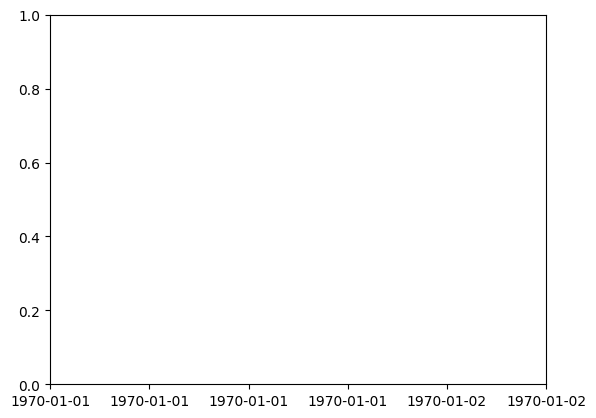

In [ ]:
all_time_chart("BID","",data)